In [58]:
import pymc as pm
import arviz as az

from scipy.stats import beta, gamma, norm, cauchy
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, ttest_rel, ttest_ind
from scipy.optimize import minimize
from pytensor import tensor as pt 

## 9.1 Equality of proportions

我们希望检验pledgers使用condom的比例（424/777）低于non-pledgers（5416/9072）
- 不假定方向的话，H0是 $\delta = 0$，H1是 $\delta \neq 0$




In [24]:
n1, n2, s1_obs, s2_obs = 777, 9072, 424, 5416
with pm.Model() as EqualityOfProportions:
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Beta('theta2', alpha = 1, beta = 1)
    delta = pm.Deterministic('delta', theta1 - theta2)
    s1 = pm.Binomial('s1', n = n1, p = theta1, observed = s1_obs)
    s2 = pm.Binomial('s2', n = n2, p = theta2, observed = s2_obs)
    prior = pm.sample_prior_predictive(draws = 10000)
    trace = pm.sample(2000)

Sampling: [s1, s2, theta1, theta2]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


Text(0.5, 1.0, 'BF =  2.187')

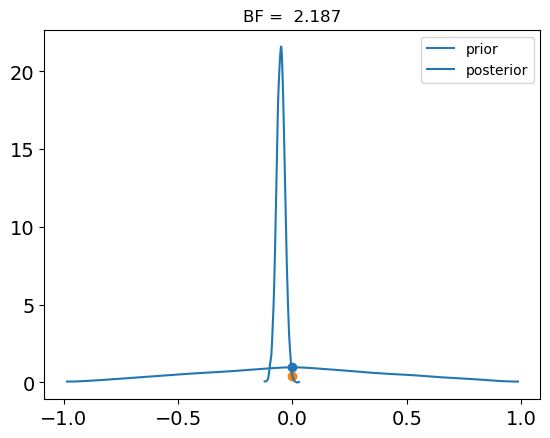

In [28]:
# BF = 2.187，比较弱的支持alternative
def get_kde_at(variable, position, labels = None):
    az.plot_dist(variable, label = labels)
    p = gaussian_kde(variable.values.flatten())(position)[0]
    plt.scatter(position, p)
    return p
p1 = get_kde_at(prior.prior['delta'], 0, 'prior')
p2 = get_kde_at(trace.posterior['delta'], 0, 'posterior')
plt.title(f'BF = {p1/p2: .3f}')

In [30]:
# delta的95%HDI不包含0，可以认为theta1<theta2
az.summary(trace, var_names=['delta'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.052,0.018,-0.088,-0.017,0.0,0.0,8225.0,5762.0,1.0


In [32]:
# Exerceis 9.1.1
## 这个问题我暂时回答不了，使用sample代替解析解，好处是换成不同的prior，依旧可以不加修改的这样做，坏处就是需要比较大的样本量和平滑函数的合理选择

# Exercise 9.1.2
## 如果我们上来就假设theta1 < theta2呢

n1, n2, s1_obs, s2_obs = 777, 9072, 424, 5416
with pm.Model() as EqualityOfProportionsOrdered:
    theta1 = pm.Beta('theta1', alpha = 1, beta = 2)
    theta2 = pm.Uniform('theta2', lower = theta1, upper = 1)
    delta = pm.Deterministic('delta', theta1 - theta2)
    s1 = pm.Binomial('s1', n = n1, p = theta1, observed = s1_obs)
    s2 = pm.Binomial('s2', n = n2, p = theta2, observed = s2_obs)
    prior = pm.sample_prior_predictive(draws = 10000)
    trace = pm.sample(2000)
az.summary(trace, var_names=['delta'], hdi_prob=0.95)

Sampling: [s1, s2, theta1, theta2]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,-0.052,0.018,-0.088,-0.016,0.001,0.0,1178.0,819.0,1.0


In [41]:
# Exercise 9.1.3
# 精确的计算结果和估计比较接近
from scipy.special import loggamma
def cnk(n, k):
    return loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)
def BF_ana(n1, n2, s1_obs, s2_obs):
    return np.exp(cnk(n1, s1_obs) + cnk(n2, s2_obs) - cnk(n1+n2, s1_obs+s2_obs)) * (n1+1) * (n2+1) / (n1+n2+1)
BF_ana(n1, n2, s1_obs, s2_obs)**(-1)

2.2234843889458524

## 9.2 Order-restricted equality of proportions

这里我们进一步假定方向：H0是 $\delta = 0$，H1是 $\delta < 0$


Sampling: [theta1, theta2]


<Axes: xlabel='theta1', ylabel='theta2'>

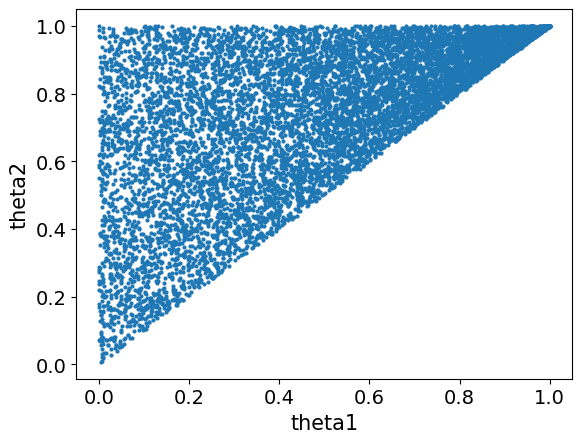

In [54]:
# 近似和精确的区别
with pm.Model() as ApproximateUniform:
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Uniform('theta2', lower = theta1, upper = 1)
    delta = pm.Deterministic('delta', theta1 - theta2)
    prior = pm.sample_prior_predictive(draws = 10000)
az.plot_pair(prior.prior, var_names=['theta1', 'theta2'])

Sampling: [s1, s2, theta1, theta2]


<Axes: xlabel='theta1', ylabel='theta2'>

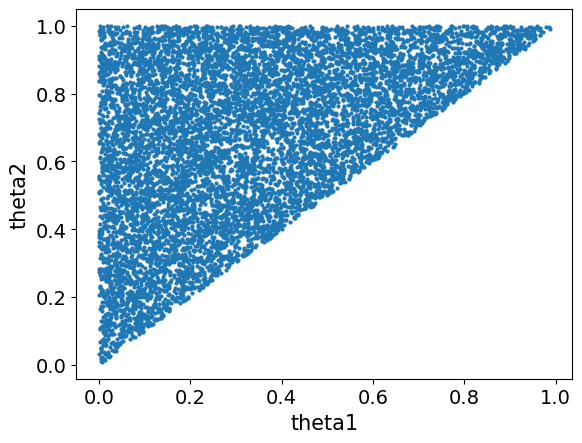

In [55]:
n1, n2, s1_obs, s2_obs = 777, 9072, 424, 5416
with pm.Model() as EqualityOfProportionsOrdered:
    theta1 = pm.Beta('theta1', alpha = 1, beta = 2)
    theta2 = pm.Uniform('theta2', lower = theta1, upper = 1)
    delta = pm.Deterministic('delta', theta1 - theta2)
    s1 = pm.Binomial('s1', n = n1, p = theta1, observed = s1_obs)
    s2 = pm.Binomial('s2', n = n2, p = theta2, observed = s2_obs)
    prior = pm.sample_prior_predictive(draws = 10000)
az.plot_pair(prior.prior, var_names=['theta1', 'theta2'])

In [57]:
# 计算BF的时候区别有点大，用全局算
with pm.Model() as EqualityOfProportions:
    theta1 = pm.Beta('theta1', alpha = 1, beta = 1)
    theta2 = pm.Beta('theta2', alpha = 1, beta = 1)
    delta = pm.Deterministic('delta', theta1 - theta2)
    s1 = pm.Binomial('s1', n = n1, p = theta1, observed = s1_obs)
    s2 = pm.Binomial('s2', n = n2, p = theta2, observed = s2_obs)
    prior = pm.sample_prior_predictive(draws = 10000)
    trace = pm.sample(2000)

Sampling: [s1, s2, theta1, theta2]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


In [62]:
prior_trace = prior.prior['delta'].values.flatten()
post_trace = trace.posterior['delta'].values.flatten()
prior_p = gaussian_kde(prior_trace)(0)[0] / 0.5
post_p = gaussian_kde(post_trace)(0)[0] / np.mean(post_trace < 0)
print(f'BF = {prior_p / post_p:.3f}')

BF = 3.722


In [63]:
# Exercise 9.2.1
## 如果是另一个方向，也是这样子更好
prior_trace = prior.prior['delta'].values.flatten()
post_trace = trace.posterior['delta'].values.flatten()
prior_p = gaussian_kde(prior_trace)(0)[0] / 0.5
post_p = gaussian_kde(post_trace)(0)[0] / np.mean(post_trace > 0)
print(f'BF = {prior_p / post_p:.3f}')

BF = 0.011


## 9.3 Comparing within-subject proportions
比较全部priming（both条件）和全不priming（neither条件）的正确率
- 很多个被试参加了测验，进行了很多轮次
- $\theta_i^b$ 和 $\theta_i^n$ 代表被试i在都学与都不学条件下的正确率，我们对 $\phi = \Phi^{-1}(\theta)$ 建模
- Neither条件下：$\phi_i^n\sim \mathcal{N}(\mu_n, \sigma_n^2)$
- 差异用 $\mu_\alpha = \delta\sigma_\alpha, \alpha_i\sim\mathcal{N}(\mu_\alpha, \sigma_\alpha^2)$ 建模
- Both条件下：$\phi_i^b = \phi_i^n + \alpha_i$

- $\Phi(x)=\frac{1}{2}​(1+\text{erf}(\frac{x}{\sqrt2}​))$

In [49]:
def Phi(x):
    return 0.5 * (1 + pt.erf(x/2**0.5))

sb = np.array([15,11,15,14,15,18,16,16,18,16,15,13,18,12,11,13,17,18,16,11,17,18,
        12,18,18,14,21,18,17,10,11,12,16,18,17,15,19,12,21,15,16,20,15,19,
        16,16,14,18,16,19,17,11,19,18,16,16,11,19,18,12,15,18,20, 8,12,19,
        16,16,16,12,18,17,11,20])
nb = 21

# Study Neither: 
sn = np.array([15,12,14,15,13,14,10,17,13,16,16,10,15,15,10,14,17,18,19,12,19,18,
        10,18,16,13,15,20,13,15,13,14,19,19,19,18,13,12,19,16,14,17,15,16,
        15,16,13,15,14,19,12,11,17,13,18,13,13,19,18,13,13,16,18,14,14,17,
        12,12,16,14,16,18,13,13])
nn = 21
n = len(sb)

# two-sided p-value = .03
ttest_rel(sb,sn)



TtestResult(statistic=2.1857463052684696, pvalue=0.0320421840966393, df=73)

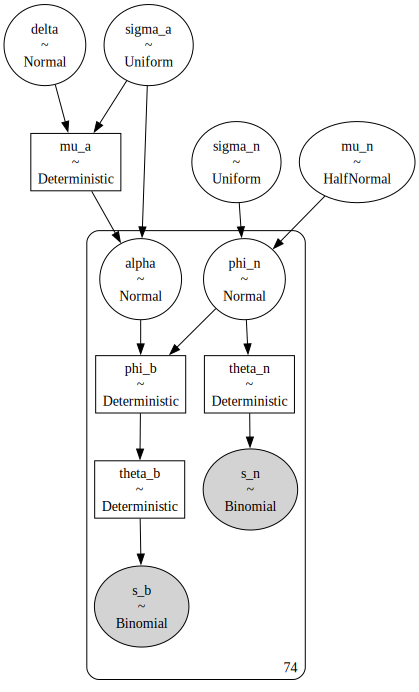

In [50]:
with pm.Model() as ComparingWithin:

    mu_n = pm.HalfNormal('mu_n', sigma = 1)
    sigma_n = pm.Uniform('sigma_n', lower = 0, upper = 10)

    delta = pm.Normal('delta', mu = 0, sigma = 1)
    sigma_a = pm.Uniform('sigma_a', lower = 0, upper = 10)
    mu_a = pm.Deterministic('mu_a', delta * sigma_a)

    phi_n = pm.Normal('phi_n', mu = mu_n, sigma = sigma_n, shape = n)
    theta_n = pm.Deterministic('theta_n', Phi(phi_n))

    alpha = pm.Normal('alpha', mu = mu_a, sigma = sigma_a, shape = n)
    phi_b = pm.Deterministic('phi_b', phi_n + alpha)
    theta_b = pm.Deterministic('theta_b', Phi(phi_b))

    s_n = pm.Binomial('s_n', n = nn, p = theta_n, observed = sn)
    s_b = pm.Binomial('s_b', n = nb, p = theta_b, observed = sb)

pm.model_to_graphviz(ComparingWithin)

In [52]:
# 95% HDI包含了0
with ComparingWithin:
    trace = pm.sample(2000)
az.summary(trace, var_names = ['delta', 'mu_n', 'mu_a'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_n, sigma_n, delta, sigma_a, phi_n, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.739,0.501,-0.068,1.850,0.018,0.019,771.0,863.0,1.0
mu_n,0.602,0.049,0.510,0.693,0.002,0.001,810.0,3128.0,1.0
mu_a,0.084,0.053,-0.017,0.177,0.004,0.001,224.0,1011.0,1.0


In [56]:
# Exercise 9.3.1
## 我没有特别搞明白怎么进行配对样本t检验可能的思路是
with pm.Model() as UsingTforBinomial:
    delta = pm.Cauchy('delta', alpha = 0, beta = 1)
    sigma = pm.HalfCauchy('sigma', beta = 1)
    mu = pm.Deterministic('mu', delta * sigma)
    diff = pm.Normal('diff', mu = mu, sigma = sigma, observed = sb-sn)
    trace = pm.sample(2000)
az.summary(trace, var_names= ['delta'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.251,0.115,0.04,0.469,0.001,0.001,8377.0,6466.0,1.0


Text(0.5, 1.0, 'BF = 1.841')

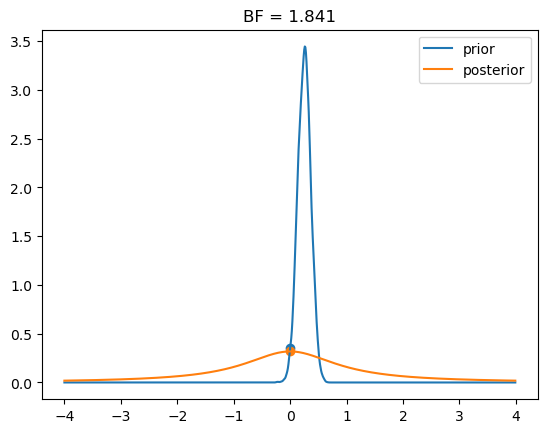

In [57]:
# 更容易得到显著的结果？但是BF很小
post_trace = trace.posterior['delta'].values.flatten()
post = gaussian_kde(post_trace)
x = np.arange(-4, 4, 0.01)
plt.plot(x, post(x), label = 'prior')
plt.scatter(0, post(0))
plt.plot(x, cauchy.pdf(x), label = 'posterior')
plt.scatter(0, cauchy.pdf(0))
plt.legend()
plt.title(f'BF = {cauchy.pdf(0) * 2 / post(0)[0] / np.mean(post_trace >=0):.3f}')

## 9.4 Comparing Between-Subject Proportions

使用WCST（威斯康星卡片排序任务）测量ADHD（52个）和正常儿童（26个）的认知灵活性
- ADHD的正确率为66.9%，正常儿童为65.4%，多大程度上支持他们没有差别

In [62]:
numerrors1 = np.array([15,10,61,11,60,44,63,70,57,11,67,21,89,12,63,11,96,10,37,19,44,
                18,78,27,60,14])
nc = np.array([89,74,128,87,128,121,128,128,128,78,128,106,128,83,128,100,128,
                73,128,86,128,86,128,100,128,79])
kc = nc - numerrors1
nsc = len(kc)

numerrors2 = np.array([88,50,58,17,40,18,21,50,21,69,19,29,11,76,46,36,37,72,27,92,13,
                39,53,31,49,57,17,10,12,21,39,43,49,17,39,13,68,24,21,27,48,54,
                41,75,38,76,21,41,61,24,28,21])
na = np.array([128,128,128,86,128,117,89,128,110,128,93,107,87,128,128,113,128,
                128,98,128,93,116,128,116,128,128,93,86,86,96,128,128,128,86,128,
                78,128,111,100,95,128,128,128,128,128,128,98,127,128,93,110,96])
ka = na - numerrors2
nsa = len(ka)
ttest_ind(kc/nc,ka/na,equal_var=False)

TtestResult(statistic=-0.3671153138223306, pvalue=0.7154583192501403, df=40.204962245940145)

Initializing NUTS using jitter+adapt_diag...
Traceback (most recent call last):
  File "/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/multiprocessing/forkserver.py", line 276, in main
    code = _serve_one(child_r, fds,
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/multiprocessing/forkserver.py", line 315, in _serve_one
    code = spawn._main(child_r, parent_sentinel)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhangxuyang/miniconda3/envs/pymc5/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu, sigma, phic, phia]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


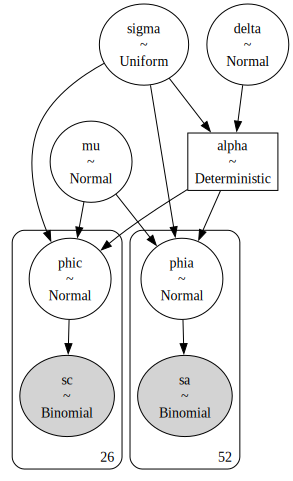

In [64]:
with pm.Model() as CompareBetweenSubject:
    
    delta = pm.Normal('delta', mu = 0, sigma = 1)
    mu = pm.Normal('mu', mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    alpha = pm.Deterministic('alpha', delta * sigma)

    phic = pm.Normal('phic', mu = mu - alpha / 2, sigma = sigma, shape = nsc)
    phia = pm.Normal('phia', mu = mu + alpha / 2, sigma = sigma, shape = nsa)
    sc = pm.Binomial('sc', n = nc, p = Phi(phic), observed = kc)
    sa = pm.Binomial('sa', n = na, p = Phi(phia), observed = ka)

    trace = pm.sample(2000)

pm.model_to_graphviz(CompareBetweenSubject)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,0.060,0.243,-0.399,0.514,0.002,0.003,10628.0,6208.0,1.0
mu,0.450,0.057,0.340,0.554,0.001,0.001,10982.0,6376.0,1.0
sigma,0.455,0.041,0.381,0.533,0.000,0.000,11610.0,6537.0,1.0
alpha,0.027,0.111,-0.187,0.232,0.001,0.001,10837.0,6038.0,1.0


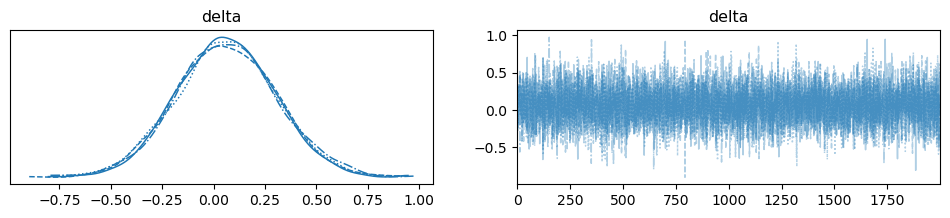

In [68]:
az.plot_trace(trace, var_names = 'delta')
az.summary(trace, var_names=['delta', 'mu', 'sigma', 'alpha'])


Text(0.5, 1.0, 'BF = 4.035')

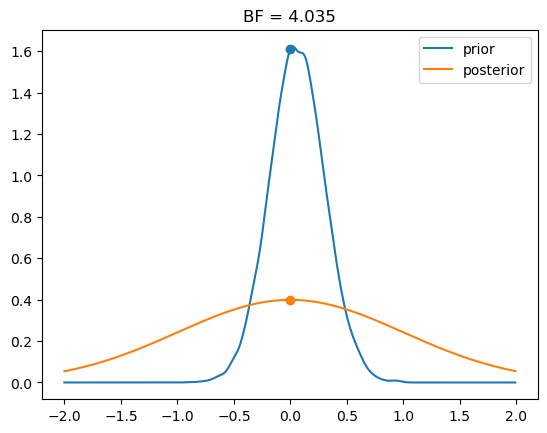

In [70]:
post_trace = trace.posterior['delta'].values.flatten()
post = gaussian_kde(post_trace)
x = np.arange(-2, 2, 0.01)
plt.plot(x, post(x), label = 'prior')
plt.scatter(0, post(0))
plt.plot(x, norm.pdf(x), label = 'posterior')
plt.scatter(0, norm.pdf(0))
plt.legend()
plt.title(f'BF = {post(0)[0]/ norm.pdf(0) :.3f}')

In [ ]:
# Exercise 9.4.1 p>0.05我们得不到任何数据，但是BF01=4我们可以知道数据支持虚无假设（无差异）的程度
# Exercise 9.4.2 直接进行t检验，还是不满足正态假设，或者说截断正态数据拟合

## 9.5 Order-restricted Between Subject Comparison


In [71]:
with pm.Model() as CompareBetweenSubjectOrdered:
    
    delta = pm.HalfNormal('delta', sigma = 1)
    mu = pm.Normal('mu', mu = 0, sigma = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    alpha = pm.Deterministic('alpha', delta * sigma)

    phic = pm.Normal('phic', mu = mu - alpha / 2, sigma = sigma, shape = nsc)
    phia = pm.Normal('phia', mu = mu + alpha / 2, sigma = sigma, shape = nsa)
    sc = pm.Binomial('sc', n = nc, p = Phi(phic), observed = kc)
    sa = pm.Binomial('sa', n = na, p = Phi(phia), observed = ka)

    trace = pm.sample(2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, mu, sigma, phic, phia]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'BF = 3.414')

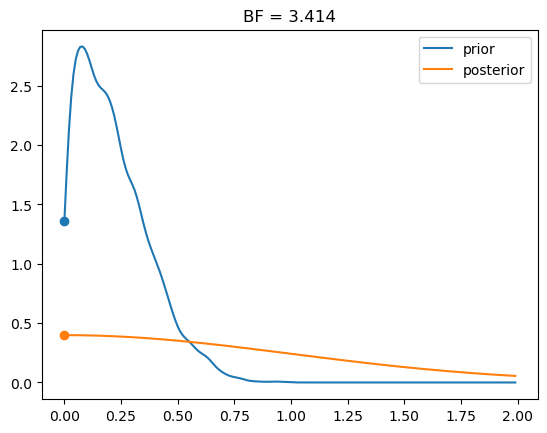

In [72]:
# 当选择了正确的方向后，支持H0的证据减弱了
post_trace = trace.posterior['delta'].values.flatten()
post = gaussian_kde(post_trace)
x = np.arange(0, 2, 0.01)
plt.plot(x, post(x), label = 'prior')
plt.scatter(0, post(0))
plt.plot(x, norm.pdf(x), label = 'posterior')
plt.scatter(0, norm.pdf(0))
plt.legend()
plt.title(f'BF = {post(0)[0]/ norm.pdf(0) :.3f}')

## 